In [1]:
from operator import itemgetter
import random
import matplotlib.pyplot as plt
import numpy as np
import queue
import pandas as pd
import random,time
import threading
from datetime import datetime, date
from io import StringIO
from multiprocessing import Pool
from multiprocessing import Process ,  Queue
from itertools import repeat
import traceback
# from random_forest import *
from adaBoost import *

In [2]:

#計算適應度
def evaluate_fitness(pop , training_data , training_data_label , train_year):
    fitness = []

    
    # processes數量
    CPU_Core_num = 6
    pool = Pool(processes = CPU_Core_num)
    # 把全部資料丟進process跑 checksize = population / proccess數量
    #cal_result = pool.starmap(random_forest_Fitness_Process , zip(pop, repeat(training_data) , repeat(training_data_label) , repeat(train_year)) , chunksize = int(len(pop) / CPU_Core_num) )
    cal_result = pool.starmap(adaBooest_Fitness_Process , zip(pop, repeat(training_data) , repeat(training_data_label) , repeat(train_year)) , chunksize = int(len(pop) / CPU_Core_num) )
    
    
    #print(cal_result)

    for r in range(len(pop)):
        fitness.append([pop[r] , cal_result[r]])
    

    return max(cal_result) , sum(cal_result)/len(pop) , fitness
    


#選擇 & 交配
def cross(pop,POP_SIZE,DNA_LEN,cross_rate):
    new_pop = []
    while len(new_pop) != POP_SIZE:
        ran_F = random.choices(pop, k=2)
        ran_M = random.choices(pop, k=2)
        father = max(ran_F, key = itemgetter(1))[0]
        mother = max(ran_M, key = itemgetter(1))[0]

        if np.random.rand() < cross_rate:
            cross_point = np.random.randint(low=0, high = DNA_LEN)
            cut_F = father[cross_point:]
            cut_M = mother[cross_point:]
            father = father[:cross_point]+cut_M
            mother = mother[:cross_point]+cut_F

        new_pop.extend([father,mother])

    return new_pop


#變異
def mutation(pop,DNA_LEN,mutation_rate):
    
    for m in range(len(pop)):
        if np.random.rand() < mutation_rate:
          mutation_gene  = np.random.randint(DNA_LEN)
          mu_chromosome = list(pop[m])
          if mu_chromosome[mutation_gene] == '1':
            mu_chromosome[mutation_gene] = '0'
          else:
            mu_chromosome[mutation_gene] = '1'
          
          pop[m] = ''.join(mu_chromosome)

    return pop


#繪製種群狀態
def draw_fitness(run,best_pop,avg_pop):
    plt.title("Best & Avg fitness")  #圖表標題
    plt.xlabel("Generation")  #圖表x軸標題
    plt.ylabel("fitness")  #圖表y軸標題
    plt.plot(run, best_pop, color='r', label='Best fitness', linestyle='-', marker='*')   #定義畫圖的顏色、圖例、線條、形狀、寬度
    plt.plot(run, avg_pop, color='b', label='Avg fitness', linestyle='--', marker='o')
    plt.grid(axis='y')    #定義網格
    plt.legend(loc='lower right')   #當有兩種以上資料,可以使用.legend()來顯示資料的圖例

In [3]:
def train( training_data , train_data_label , train_years):
    run = []
    best_fitness = []
    avg_fitness = []

    POP_SIZE = 400    #種群大小
    

    DNA_LEN = get_DNA_length()    # 
    cross_rate = 0.7    #交配概率
    mutation_rate = 0.005   #變異概率

    #初始種群
    pop = init_population(POP_SIZE)


    #迭代次數
    generation_num = 30
    best_chromosome = ""
    best_fit = -1e9


    for i in range(generation_num):
        print(f"[Generation : {i+1}]")
        max_fit , avg_fit, pop = evaluate_fitness(pop , training_data , train_data_label , train_years) #計算適應度
        # print(f" Best chromosome : {random_forest_decode(sorted(pop, reverse=True, key = itemgetter(1))[0][0])}\n {sorted(pop, reverse=True, key = itemgetter(1))[0][0]}\n Best fitness:{max_fit}\n Avg fitness:{avg_fit}\n")
        print(f" Best chromosome:{adaBoost_decode(sorted(pop, reverse=True, key = itemgetter(1))[0][0])}\n Best fitness:{max_fit}\n Avg fitness:{avg_fit}\n")

        if best_fit < max_fit :
            best_fit = max_fit
            best_chromosome = sorted(pop, reverse=True, key = itemgetter(1))[0][0]

        pop = cross(pop,POP_SIZE,DNA_LEN,cross_rate)  #交配 
        pop = mutation(pop,DNA_LEN,mutation_rate) #變異

        best_fitness.append(max_fit)
        avg_fitness.append(avg_fit)
        run.append(i+1)

    draw_fitness(run,best_fitness,avg_fitness)

    return best_chromosome


In [4]:
def select_stock_and_get_IRR(best_model , drop_columns , train_years , stocks_data , data_years , buy_num):
    
    total_gain = 100
    gain_list = pd.DataFrame(np.array([[0,0,0]]) ,columns = ['Gain' , 'predict' , 'correct'])
    
    
    
    for years in range(train_years+1 , 10):
        test_data = stocks_data[stocks_data['年月'].isin(data_years[years:years+1])]
        test_data_label = test_data['Return']
        test_stock_list = test_data['簡稱']
        test_data = test_data.drop(columns=['簡稱', '年月', 'Return', 'ReturnMean_year_Label'])

        # pred_label = random_forest_validate(best_model , drop_columns , test_data , test_data_label , years)
        pred_label = adaBoost_validate(best_model , drop_columns , test_data , test_data_label , years)
        pred_label.insert( loc = 0, column='簡稱' , value = test_stock_list.to_numpy())

        pred_label = pred_label.sort_values(by=['return'] , ascending=False)
     
        #print(test_stock_list)
        #print(pred_label)
        #print(pred_label.iloc[0]['return'])

        next_year_return = 0
        pred_year_return = 0

        for idx in range(buy_num):
            stock_name = pred_label.iloc[idx]['簡稱']
            next_year_return += stocks_data[ (stocks_data['簡稱'] == stock_name) & (stocks_data['年月'] == data_years[years] ) ]["Return"].to_numpy()[0]
            pred_year_return += pred_label.iloc[idx]["return"]

            #print(years ," / " , idx , " / " , stocks_data[ (stocks_data['簡稱'] == stock_name) & (stocks_data['年月'] == data_years[years] ) ]["Return"].to_numpy()[0] , "/" , stock_name)

        next_year_return /= buy_num
        pred_year_return /= buy_num
        #print(stock_name)
        # print(data_years[years])
        #print(stocks_data[ (stocks_data['簡稱'] == stock_name) & (stocks_data['年月'] == data_years[years] ) ]["Return"])


        #print(next_year_return)

    
        total_gain *= (100 + next_year_return) / 100

        #print(pred_label.iloc[1]["return"])

        new_row = pd.Series({"Gain" : total_gain , "predict" : pred_label.iloc[1]["return"], 'correct' :  next_year_return})


        gain_list = pd.concat([gain_list, new_row.to_frame().T], ignore_index=True, axis=0)
        # print(stocks_data[(stocks_data['簡稱'] == stock_name) ])

    # years_name = stocks_data[stocks_data['年月'].isin(data_years[train_years:])][''].to_numpy()
    #print(gain_list)
    #print(data_years[train_years:])

    years_name = []

    for i in range(len(data_years[train_years:])):
        years_name.append(str(data_years[train_years:][i])[:4] + "/" + str(data_years[train_years:][i])[4:] + "/1")


    fig = go.Figure()
    fig.add_trace(go.Scatter(x=years_name, y=gain_list["Gain"], name = "Gain"))
    fig.add_trace(go.Scatter(x=years_name, y=gain_list["predict"], name = "predict"))
    fig.add_trace(go.Scatter(x=years_name, y=gain_list["correct"], name = "correct"))
    fig.show()
    print("Total Gain" , total_gain)

    print("IRR " , (( (total_gain/100) ** ( 1 / (10-train_years)))-1 ) * 100)

[Generation : 1]
 Best chromosome:(20, {'max_depth': 4, 'max_features': 0.41732283464566927, 'criterion': 'absolute_error', 'min_samples_leaf': 0.001, 'min_samples_split': 0.22834645669291337, 'random_state': 0}, ['市值(百萬元)', '股價營收比', 'M淨值報酬率─稅後', '資產報酬率ROA', 'M流動比率', 'M速動比率', 'M存貨週轉率 (次)', 'M營業利益成長率'])
 Best fitness:0.37401201305700715
 Avg fitness:0.0009220501081761395

[Generation : 2]
 Best chromosome:(48, {'max_depth': 4, 'max_features': 0.30708661417322836, 'criterion': 'absolute_error', 'min_samples_leaf': 0.007874015748031496, 'min_samples_split': 0.06299212598425197, 'random_state': 0}, ['本益比', '營業利益率OPM', '負債/淨值比', 'M存貨週轉率 (次)', 'M營業利益成長率'])
 Best fitness:0.5147407801973343
 Avg fitness:0.06352686958378499

[Generation : 3]
 Best chromosome:(48, {'max_depth': 4, 'max_features': 0.30708661417322836, 'criterion': 'absolute_error', 'min_samples_leaf': 0.007874015748031496, 'min_samples_split': 0.06299212598425197, 'random_state': 0}, ['本益比', '利潤邊際NPM', '負債/淨值比', 'M速動比率', 'M存貨週轉率 

NameError: name 'best_model' is not defined

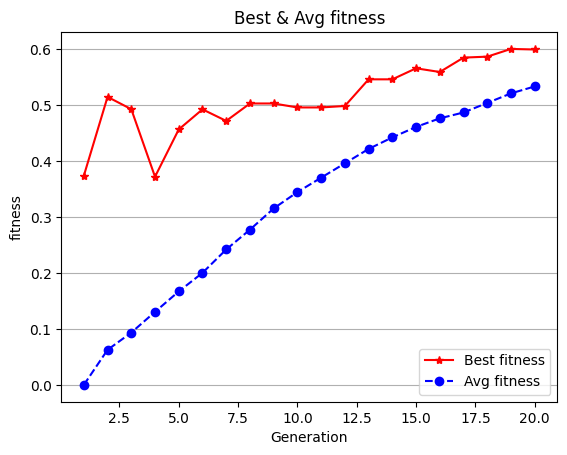

In [5]:
if __name__ == '__main__':  
    data = pd.read_csv('./top200_training.csv')  #讀取csv資料檔

    stocks_data = pd.read_csv('./top200_training.csv' )
    stocks_data = stocks_data.drop(columns=['證券代碼'])
    data_years = stocks_data['年月'].unique()

       # for split_year in split_year_li:
    for train_years in range(5,6):

        train_data = stocks_data[stocks_data['年月'].isin(data_years[:train_years])]
        train_data_label = train_data['Return']
        train_data = train_data.drop(columns=['簡稱', '年月', 'Return', 'ReturnMean_year_Label'])

        best_chromosome = train(train_data , train_data_label , train_years)
        # best_model , drop_columns = get_best_model("101001110100001011111101111110000011010" ,train_data , train_data_label)

        select_stock_and_get_IRR(best_model , drop_columns , train_years , stocks_data , data_years , 10)
        # test_data = stocks_data[stocks_data['年月'].isin(data_years[train_years:-1])]
        # test_data_label = test_data['Return']
        # test_data = test_data.drop(columns=['簡稱', '年月', 'Return', 'ReturnMean_year_Label'])
        

        
        # train出最好的染色體
        #pred_data = random_forest_validate(best_chromosome ,train_data , train_data_label , test_data , test_data_label , 3)
        # best_model , drop_columns = get_best_model("101001110100001011111101111110000011010" ,train_data , train_data_label)
        # pred_label = random_forest_validate(best_model , drop_columns , test_data , test_data_label , 3)
        # pred_label.insert( loc = 0, column='簡稱' , value = stocks_data['簡稱'])

        # print(pred_label.sort_values(by=['return'] , ascending=False))



In [ ]:
# 101001110100001011111101111110000011010
print(random_forest_validate("101001110100001011111101111110000011010" ,train_data , train_data_label , test_data , test_data_label , 3))
